In [ ]:
import os

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from datasets import concatenate_datasets, load_dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from ddpm import Diffusion
from model import DiffusionUNet, DiffusionUNetConfig
from utils import HFDatasetWrapper, torch_get_device

device = torch_get_device()
print(f"using {device}")

rng_seed = 31415
torch.manual_seed(rng_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(rng_seed)

using mps


## Params

In [ ]:
dataset = "tiny-imagenet"
noise_steps = 200
lr = 1e-3
n_epochs = 500
batch_size = 32
save_every_epoch = 1
vis_every_epoch = 1
img_size = 32, 32
img_chls = 1 if dataset=="mnist" else 3

## Dataset

In [ ]:
train_ds = load_dataset('Maysee/tiny-imagenet', split='train', cache_dir=None)
val_ds = load_dataset('Maysee/tiny-imagenet', split='valid', cache_dir=None)
combined_ds = concatenate_datasets([train_ds, val_ds])
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(), # 0 to 1
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(lambda x: x * 2 - 1), # -1 to 1
])
torch_ds = HFDatasetWrapper(combined_ds, transform)
dataloader = DataLoader(torch_ds, batch_size=batch_size, shuffle=True, drop_last=True)

### Visualize

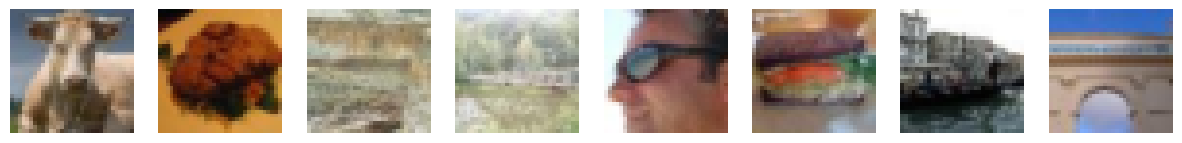

In [ ]:
imgs = next(iter(dataloader))
assert imgs.shape[0] >= 8

fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = imgs[i].clone().detach().cpu().numpy().transpose(1, 2, 0)
    img = (img + 1) * 0.5
    ax.imshow(img)
    ax.axis("off")
plt.show()

## Model

In [ ]:
config = DiffusionUNetConfig(inp_size=img_size, inp_chls=img_chls)
model = DiffusionUNet(config)
print(f"Num params: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}Mn")
model

Num params: 15.64Mn


DiffusionUNet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Downsample(
      (time_mlp): Linear(in_features=32, out_features=64, bias=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Downsample(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (tran

## Init

In [ ]:
def save_ckpt(model, config, epoch, loss):
    os.makedirs("logs", exist_ok=True)
    file_path = f"logs/diffusion-{epoch:05d}.pt"
    torch.save({
        'model': model.state_dict(),
        'config': config,
        'epoch': epoch,
        'loss': loss,
        'noise_steps': noise_steps
    }, file_path)
    print(f"Saved checkpoint to {file_path}")

def visualize_reverse_process(debug_imgs, epoch, img_chls=3, img_size=(32, 32)):
    assert debug_imgs.ndim == 5
    assert debug_imgs.shape[2:] == (img_chls, *img_size)

    num_samples, num_timesteps = debug_imgs.shape[0], debug_imgs.shape[1]
    rows, cols = num_timesteps, num_samples
    
    debug_imgs = debug_imgs.permute(0, 1, 3, 4, 2)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c] if rows > 1 else axes[c]
            ax.imshow(debug_imgs[c, r])
            ax.axis('off')
    
    fig.suptitle(f"Epoch {epoch}", fontsize=16)
    plt.tight_layout()
    plt.show()

diffusion = Diffusion(noise_steps, img_size=img_size, img_chnls=img_chls, device=device)
optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95))

model.to(device);

DiffusionUNet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Downsample(
      (time_mlp): Linear(in_features=32, out_features=64, bias=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Downsample(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (tran

## Training

In [ ]:
for epoch in range(1, n_epochs + 1):
    model.train()
    loss_sum = 0.0
    print(f"Epoch {epoch}/{n_epochs}")
    
    progress_bar = tqdm(dataloader, ncols=150, desc="Training", leave=False)
    
    for step, batch in enumerate(progress_bar):
        batch = batch.to(device)
        optimizer.zero_grad()
        
        t = diffusion.sample_timesteps(batch_size)
        x_noisy, noise = diffusion.forward(batch, t)
        
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise, noise_pred)
        loss_sum += loss.item()
        
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = loss_sum / len(dataloader)
    print(f"Avg Loss: {avg_loss:.4f}")
    
    if epoch % vis_every_epoch == 0:
        model.eval()
        with torch.no_grad():
            model.eval()
            _, debug_imgs = diffusion.reverse(model, n=2, debug=True)
            visualize_reverse_process(debug_imgs, epoch)
            model.train()
    
    if epoch % save_every_epoch == 0:
        save_ckpt(model, config, epoch, avg_loss)

 40%|███████████████████████▌                                   | 1374/3437 [03:15<04:54,  7.01it/s]


KeyboardInterrupt: 